In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad

In [2]:
table = pd.read_csv('Heston_data_input')
X = table.drop(['C_price','delta'], axis=1)
y = table[['C_price']]
#X = df[['k','T','C_price']]
#y = df[['v0','rho','kappa','theta','sigma']]

In [3]:
table['C_price'].describe()

count    63.000000
mean      0.285844
std       0.134396
min       0.005952
25%       0.251236
50%       0.289855
75%       0.381712
max       0.452502
Name: C_price, dtype: float64

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.2, random_state=42)
input_scaler = preprocessing.MinMaxScaler()
output_scaler = preprocessing.MinMaxScaler()
X_train_scaled = input_scaler.fit_transform(X_train)
#y_train_scaled = output_scaler.fit_transform(y_train)
#y_train_scaled = y_train # no scaling
#X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0],X_train_scaled.shape[1],1) # for lstm
X_test_scaled = input_scaler.transform(X_test)
#y_test_scaled = y_test # no scaling

X_train_scaled = torch.FloatTensor(X_train_scaled)
X_test_scaled = torch.FloatTensor(X_test_scaled)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [5]:

num_neurons = 128


class Net(nn.Module):

    def __init__(self,num_input=7):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_input, num_neurons) 
        self.fc2 = nn.Linear(num_neurons, num_neurons)
        self.fc3 = nn.Linear(num_neurons, num_neurons)
#        self.fc4 = nn.Linear(num_neurons, num_neurons)
#        self.fc5 = nn.Linear(num_neurons, num_neurons)
#        self.fc6 = nn.Linear(num_neurons, num_neurons)
        self.fc7 = nn.Linear(num_neurons, 1)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
#        x = F.relu(self.fc3(x))
#        x = F.relu(self.fc4(x))
#        x = F.relu(self.fc5(x))
#        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        return x

def weights_init(m,init_type='normal'):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
#        torch.nn.init.normal_(m.weight)
#        xavier(m.weight.data)
#        xavier(m.bias.data)


In [6]:
model = Net()
model.apply(weights_init)
        
print(model)

Net(
  (fc1): Linear(in_features=7, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=1, bias=True)
)


# Training

In [7]:
epochs = 30001
epochs = 101
loss_arr = []
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-3)
l2_lambda = 1e-5
criterion = nn.MSELoss()


for i in range(epochs):
    y_hat = model.forward(X_train_scaled)
    loss = criterion(y_hat, y_train)
    l2_reg = torch.tensor(0.)
    for param in model.parameters():
        l2_reg += torch.norm(param)
        loss += l2_lambda * l2_reg
    loss_arr.append(loss)
    
 
    if i % 500 == 0:
        print(f'Epoch: {i} Loss: {loss}')
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 Loss: 0.04213423654437065


C:\Users\golde\Anaconda3\lib\site-packages\torch\nn\functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


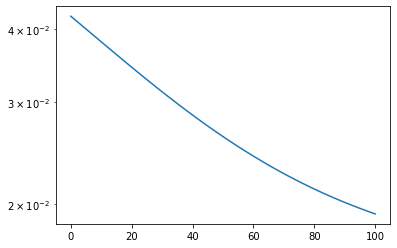

In [8]:
plt.plot(loss_arr)
plt.yscale('log')

In [9]:
inp = copy.deepcopy(X_train_scaled[0])
inp.requires_grad = True

In [10]:
out=model.forward(inp)

In [11]:
out.backward()

In [12]:
inp.grad

tensor([ 0.0038,  0.0323, -0.0131, -0.0647,  0.0328,  0.0064, -0.0159])

In [31]:
inp1 = copy.deepcopy(X_train_scaled[0])
dx = 1e-3
inp1[0] = torch.add(inp1[0],dx)

In [32]:
out1= model.forward(inp1)
dy = out1 - out
print(dy)

tensor([3.7551e-06], grad_fn=<SubBackward0>)


In [33]:
dydx = dy/dx

In [68]:
# 2nd order diff
x = []
ind = 0
tmp = X_train_scaled[0].clone().detach(); tmp.requires_grad = True
tmp[ind] -= dx
x.append(tmp)
tmp = X_train_scaled[0].clone().detach(); tmp.requires_grad = True
x.append(tmp)
tmp = X_train_scaled[0].clone().detach(); tmp.requires_grad = True
tmp[ind] += dx
x.append(tmp)
y = []
for elem in x:
    y.append(model.forward(elem))

dydx_fd = (y[2] - y[1]) / dx
d2ydx2_fd = (y[2] + y[0] - 2.*y[1]) / dx**2
print('1st diff FD ',dydx_fd)
print('2nd diff FD ',d2ydx2_fd)

1st diff FD  tensor([0.0038], grad_fn=<DivBackward0>)
2nd diff FD  tensor([-0.0596], grad_fn=<DivBackward0>)


# autograd

In [69]:
x = X_train_scaled[0].clone().detach()
x.requires_grad = True
y= model.forward(x)

In [70]:
dydx = grad(y,x, create_graph = True)[0]

In [71]:
dydx[0]

tensor(0.0038, grad_fn=<SelectBackward>)

In [72]:
d2ydx2 = grad(dydx[0],x, create_graph = True)[0]

In [73]:
d2ydx2

tensor([ 1.4393e-05, -1.4361e-04, -9.0539e-05,  2.5314e-04, -9.3472e-05,
        -4.3950e-05, -1.0517e-04], grad_fn=<SqueezeBackward1>)

In [74]:
x[0]

tensor(0.5000, grad_fn=<SelectBackward>)